In [16]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
import pandas as pd
import numpy as np

from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import (chi2, mutual_info_classif, f_classif)

from utils.constants import STAGE_DIR
from utils.dataload import load_data
from utils.display import cdisplay
from utils.plots import plot_features_scores
from utils.transformers import SelectKBestTransformer, ReliefFTransformer

In [18]:
X_train = load_data(STAGE_DIR / 'preprocess' / 'X_train.parquet', load_func=pd.read_parquet)
X_test = load_data(STAGE_DIR / 'preprocess' / 'X_test.parquet', load_func=pd.read_parquet)
y = load_data(STAGE_DIR / 'preprocess' / 'y.parquet', load_func=pd.read_parquet)

# Univariate feature selection

## Chi-squared $\chi^2$

In [19]:
univariate_selection_1 = SelectKBestTransformer(chi2, k=40)
univariate_selection_1 = univariate_selection_1.fit(X_train, y)
univariate_features_train_1 = univariate_selection_1.transform(X_train)
univariate_features_test_1 = univariate_selection_1.transform(X_test)

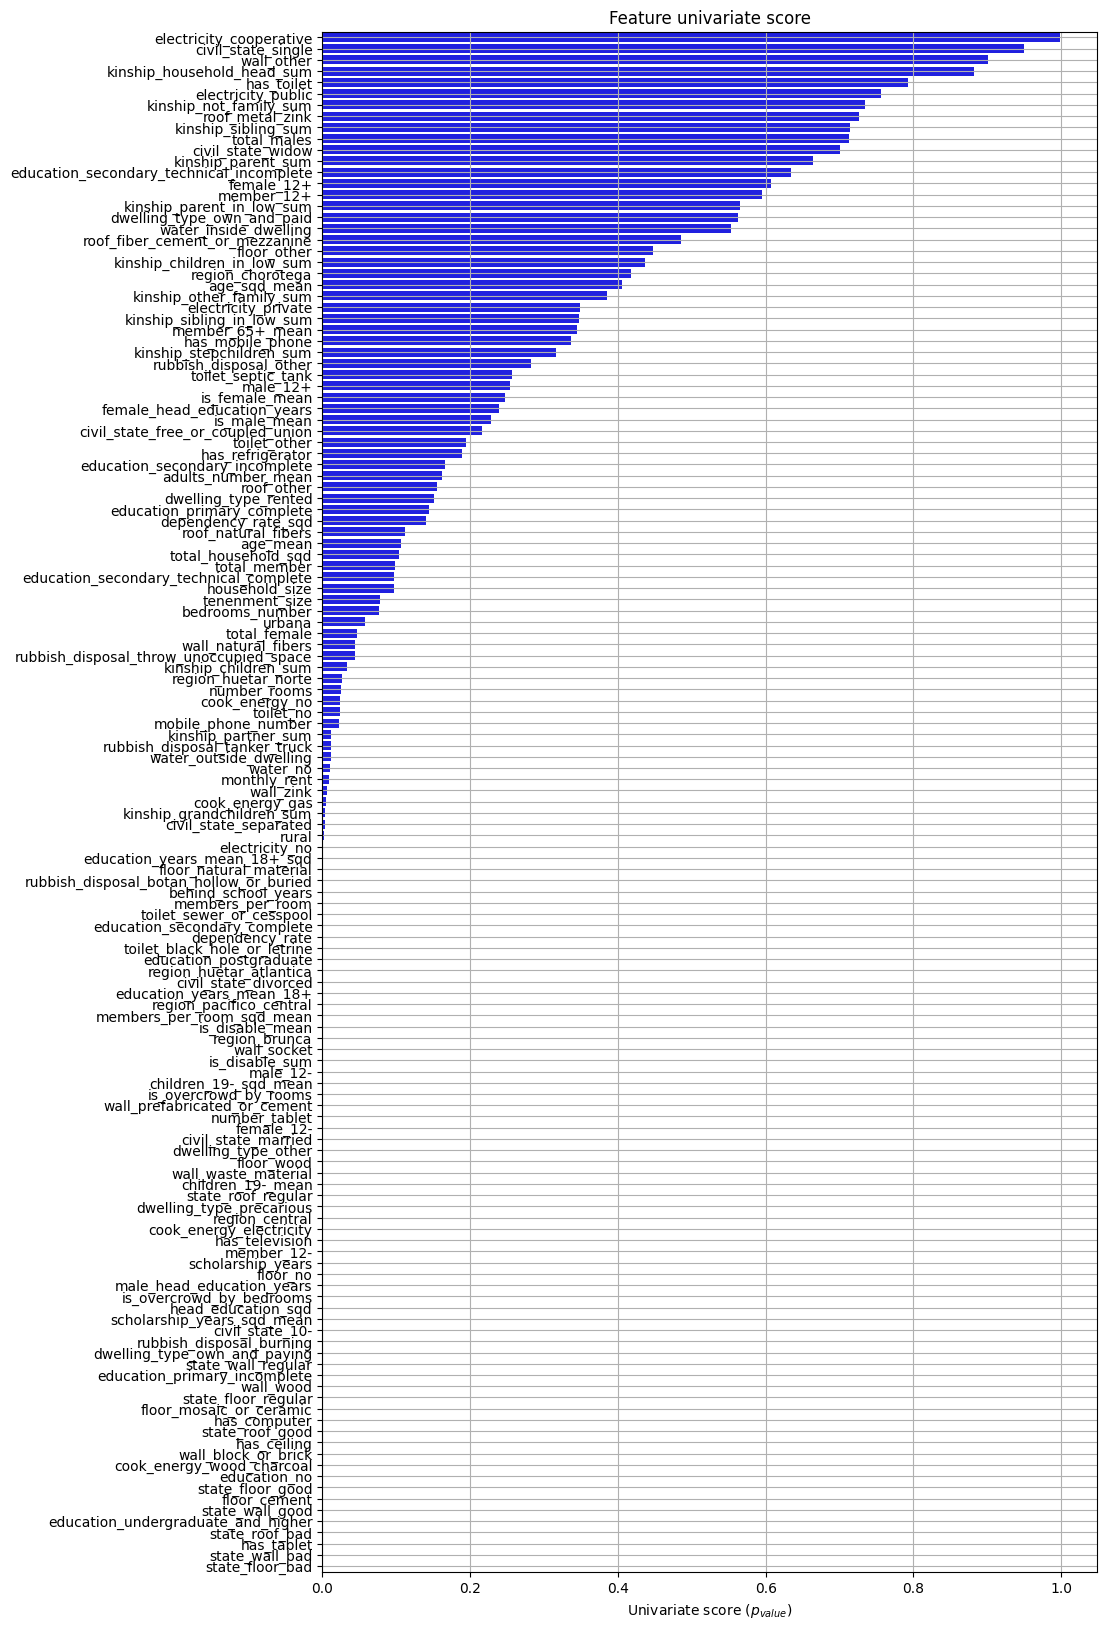

In [20]:
scores_1 = univariate_selection_1.pvalues_
plot_features_scores(X_train, scores_1, metric_label=r'$p_{value}$')

## Mutual information

In [21]:
univariate_selection_2 = SelectKBestTransformer(mutual_info_classif, k=100)
univariate_selection_2 = univariate_selection_2.fit(X_train, y['y'])
univariate_features_train_2 = univariate_selection_2.transform(X_train)
univariate_features_test_2 = univariate_selection_2.transform(X_test)

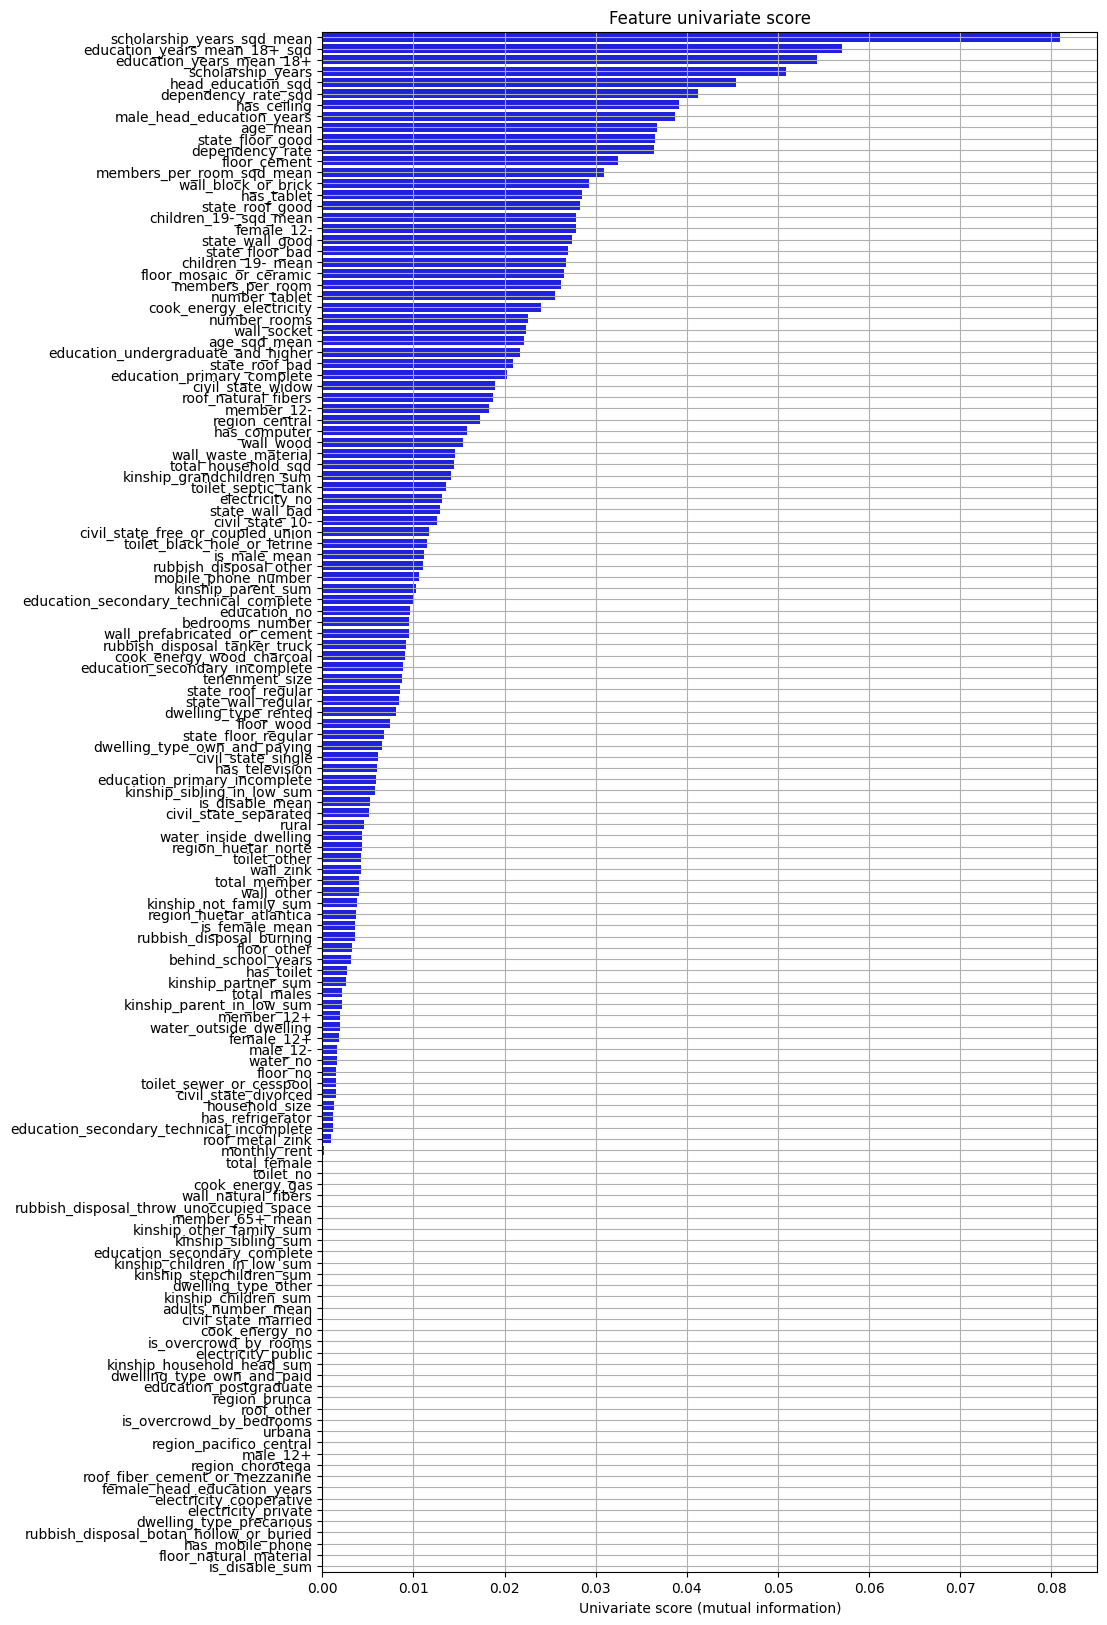

In [22]:
scores_2 = univariate_selection_2.scores_
plot_features_scores(X_train, scores_2, metric_label=r'mutual information')

## ANOVA selection

In [23]:
univariate_selection_3 = SelectKBestTransformer(f_classif, k=100)
univariate_selection_3 = univariate_selection_3.fit(X_train, y['y'])
univariate_features_train_3 = univariate_selection_3.transform(X_train)
univariate_features_test_3 = univariate_selection_3.transform(X_test)

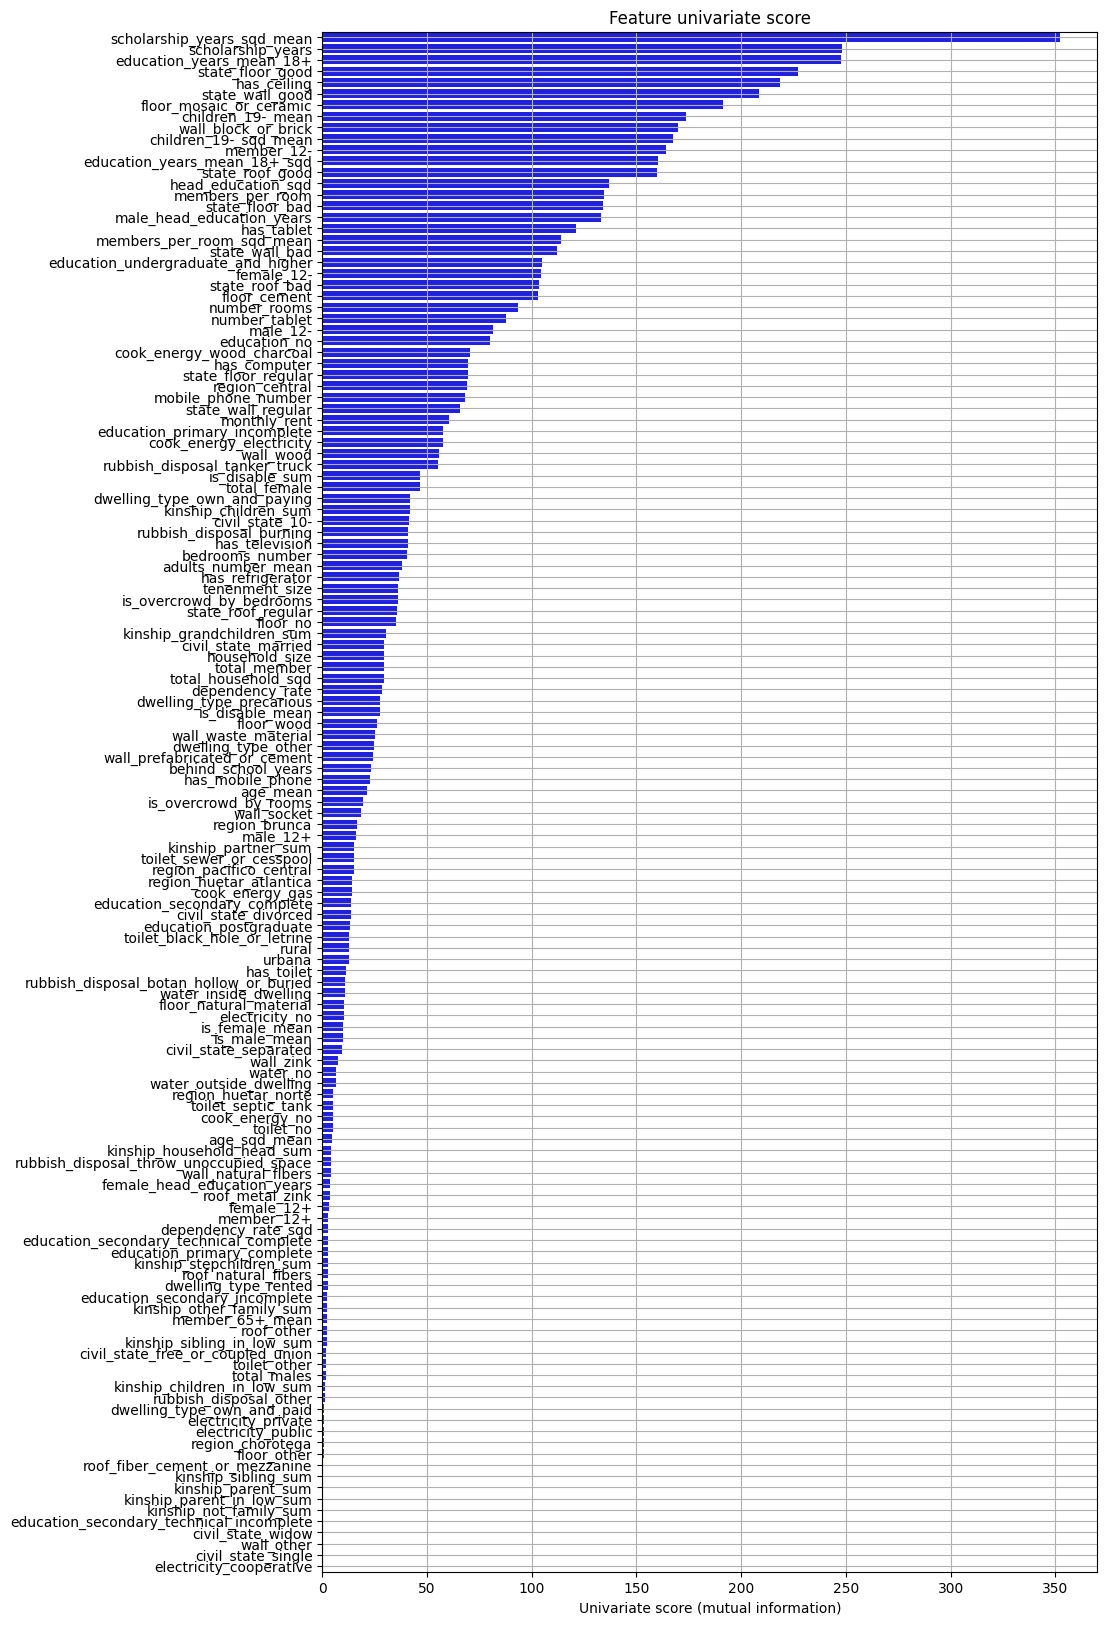

In [24]:
scores_3 = univariate_selection_3.scores_
plot_features_scores(X_train, scores_3, metric_label=r'mutual information')

# Multivariate feature selection

In [25]:
multivariate_selection = ReliefFTransformer(n_features_to_keep=100)
multivariate_selection.fit(X_train, y)
multivariate_features_train = multivariate_selection.transform(X_train)
multivariate_features_test = multivariate_selection.transform(X_test)

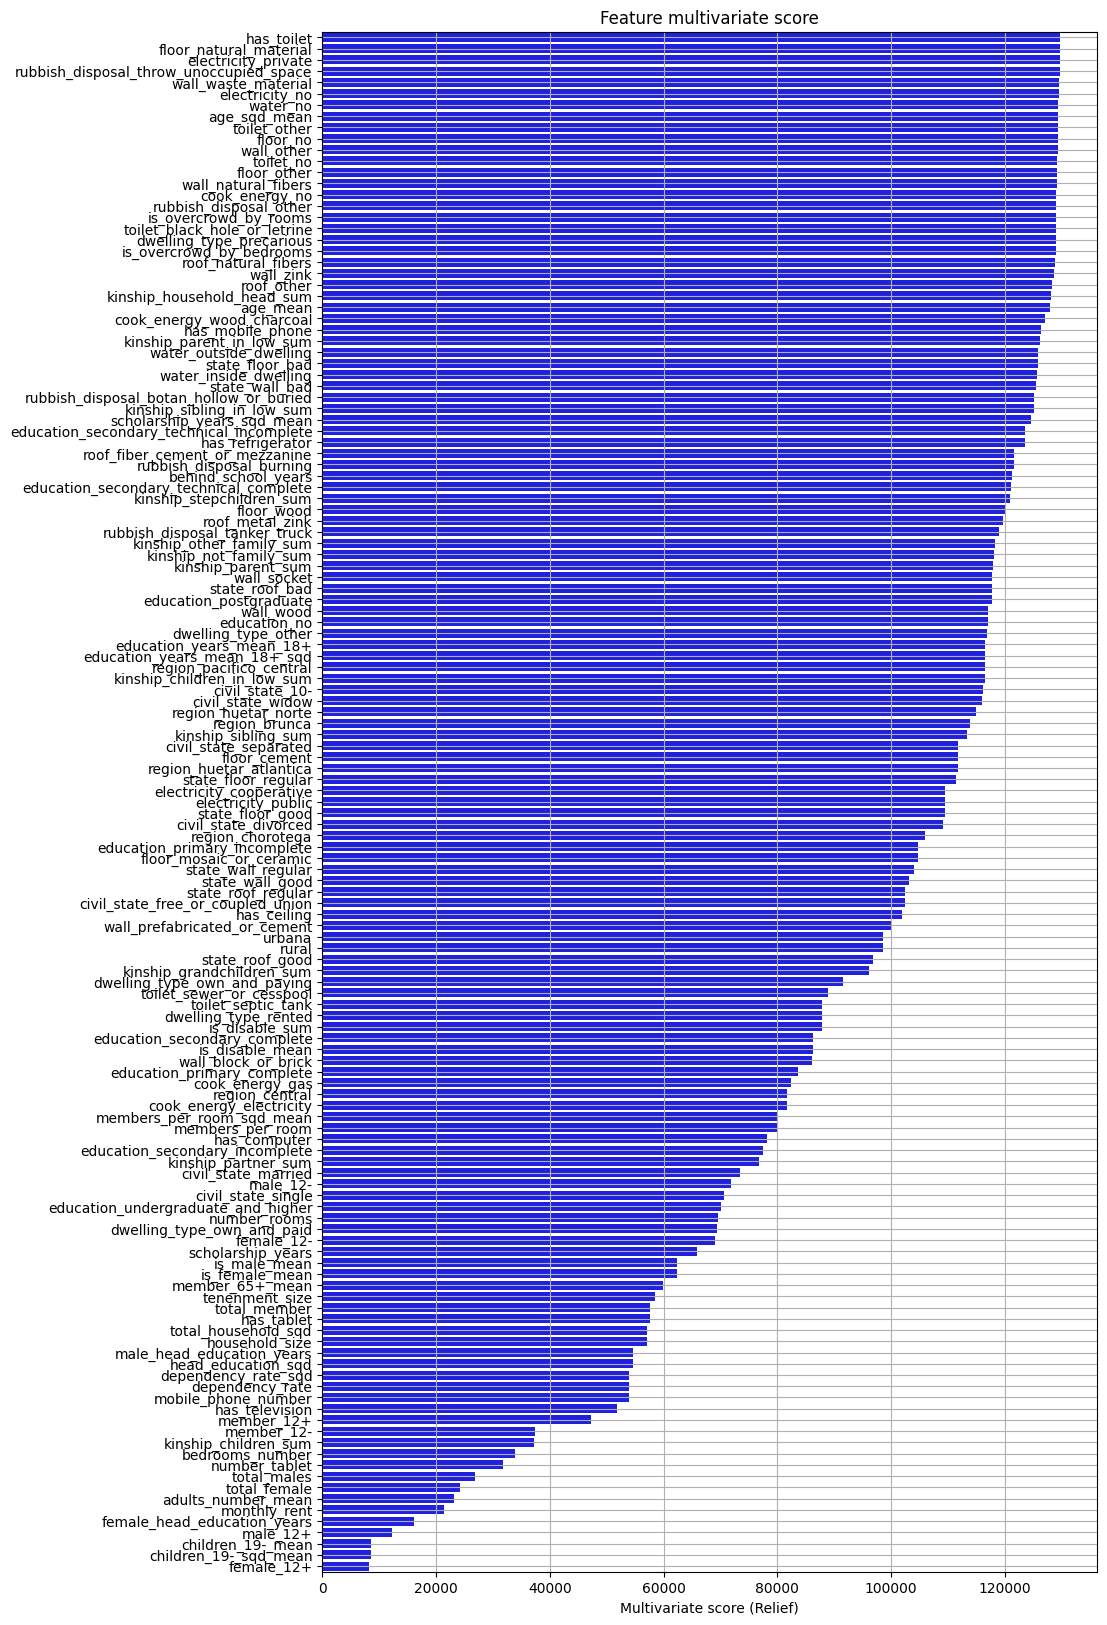

In [26]:
plot_features_scores(X_train, abs(multivariate_selection.feature_scores), method='multivariate', metric_label='Relief')

# Save selected datasets

In [27]:
univariate_features_train_1.to_parquet(STAGE_DIR / 'selection' / 'X_train_x2.parquet')
univariate_features_test_1.to_parquet(STAGE_DIR / 'selection' / 'X_test_x2.parquet')

In [28]:
univariate_features_train_2.to_parquet(STAGE_DIR / 'selection' / 'X_train_mi.parquet')
univariate_features_test_2.to_parquet(STAGE_DIR / 'selection' / 'X_test_mi.parquet')

In [29]:
univariate_features_train_3.to_parquet(STAGE_DIR / 'selection' / 'X_train_anova.parquet')
univariate_features_test_3.to_parquet(STAGE_DIR / 'selection' / 'X_test_anova.parquet')

In [30]:
multivariate_features_train.to_parquet(STAGE_DIR / 'selection' / 'X_train_relief.parquet')
multivariate_features_test.to_parquet(STAGE_DIR / 'selection' / 'X_test_relief.parquet')